# Finding routes for appliance delivery with Vehicle Routing Problem Solver


The network module of the ArcGIS API for Python can be used to solve different types of network analysis operations. For example, an appliance delivery company wants to serve multiple customers in a day using several delivery drivers, a health inspection company needs to schedule inspection visits for the inspectors. The problem that is common to these examples is called vehicle routing problem (VRP). Each such problem requires to determine which orders should be serviced by which vehicle/driver and in what sequence, so the total operating cost is minimized and the routes are operational. In addition, the VRP solver can solve more specific problems because numerous options are available, such as matching vehicle capacities with order quantities, giving breaks to drivers, and pairing orders so they are serviced by the same route.

In this sample, we find a solution for an appliance delivery company to find routes for two vehicles which start from the warehouse and return to the same at the end of the working day. We will find optimized routes given a set of orders to serve and a set of vehicles with constraints. All we need to do is pass in the `depot` locations, `route` (vehicle/driver) details, the `order` locations, and specify additional properties for `orders`.  The VRP service will return `routes` with directions. Once you have the results you can add the `routes` to a map, display the turn-by-turn directions, or integrate them further into your application. To learn more about the capabilities of the routing and directions services, please visit the [documentation](http://desktop.arcgis.com/en/arcmap/latest/extensions/network-analyst/vehicle-routing-problem.htm#).

**Note** :If you run the tutorial using ArcGIS Online, 2 [credits](http://pro.arcgis.com/en/pro-app/tool-reference/appendices/geoprocessing-tools-that-use-credits.htm#ESRI_SECTION2_5FAF16DB9F044F78AF164A22752A9A7F) will be consumed.

As a first step, let's import required libraries and establish a connection to your organization which could be an ArcGIS Online organization or an ArcGIS Enterprise. If you dont have an ArcGIS account, [get ArcGIS Trial](https://www.esri.com/en-us/arcgis/trial).

In [1]:
import arcgis
from arcgis.gis import GIS
import pandas as pd
import datetime
import getpass
from IPython.display import HTML

from arcgis import geocoding
from arcgis.features import Feature, FeatureSet

In [2]:
portal_url = 'https://www.arcgis.com'
#connect to your GIS
user_name = '<user_name>'
password = '<password>'
my_gis = GIS(portal_url, user_name, password)

To solve the Vehicle Routing Problem, we need `orders` layer with stop information, `depots` layer with the warehouse location information from where the routes start and `routes` table with constraints on routes like maximum total time the driver can work etc.
To provide this information to the service, different types of inputs are supported as listed below:

- Csv file
- Address information to geocode or reverse geocode
- Json file

Let us see how to get the layer from each of these input types.

### Create orders layer with csv file:
Orders CSV file has an `Address` column. So, we convert orders CSV to a SpatialDataFrame using the address values to geocode order locations.To perform the geocode operations, we imported the geocoding module of the ArcGIS API.

In [3]:
orders_csv = "data/orders.csv"

# Read the csv file and convert the data to feature set
orders_df = pd.read_csv(orders_csv)
orders_sdf = arcgis.features.SpatialDataFrame.from_df(orders_df, "Address")
orders_fs = orders_sdf.to_featureset()

In [4]:
orders_sdf.head(3)

,Address,SHAPE
0,"855 La Playa St, San Francisco, California, 94121","{'x': -122.51000717199997, 'y': 37.77222479500..."
1,"90 W Manor Dr, Pacifica, California, 94044","{'x': -122.49172837699996, 'y': 37.64931769600..."
2,"22 Plymouth Ave, Mill Valley, California, 94941","{'x': -122.53238122599998, 'y': 37.89567777300..."


### Create routes layer with csv file:

To get a featureset from dataframe, we convert the CSV to a pandas data frame using read_csv function. Note that in our CSV, `EarliestStartTime` and `LatestStartTime` values are represented as strings denoting time in the local time zone of the computer. So we need to parse these values as date-time values which we accomplish by specifying to_datetime function as the datetime parser.

When calling `arcgis.network.analysis.solve_vehicle_routing_problem` function we need to pass the datetime values in milliseconds since epoch. The `routes_df` dataframe stores these values as datetime type. We convert from datetime to int64 datatype which stores the values in nano seconds. We then convert those to milliseconds.


In [5]:
routes_csv = "data/routes.csv"

# Read the csv file
routes_df = pd.read_csv(routes_csv, parse_dates=["EarliestStartTime", "LatestStartTime"], date_parser=pd.to_datetime)
routes_df["EarliestStartTime"] = routes_df["EarliestStartTime"].astype("int64") / 10 ** 6
routes_df["LatestStartTime"] = routes_df["LatestStartTime"].astype("int64") / 10 ** 6
routes_fs = arcgis.features.FeatureSet.from_dataframe(routes_df)

In [6]:
routes_df

,ObjectID,Name,StartDepotName,EndDepotName,EarliestStartTime,LatestStartTime,Capacities,CostPerUnitTime,MaxOrderCount,MaxTotalTime,AssignmentRule
0,1,Route1,Warehouse,Warehouse,-2.209133e+12,-2.209126e+12,6,20,6,150,1
1,2,Route2,Warehouse,Warehouse,-2.209133e+12,-2.209126e+12,6,20,6,150,1


### Create depots layer with csv file:
Depots CSV file has depot locations in columns called `Latitude` (representing Y values) and `Longitude` (representing X values). So, we convert depots CSV to a SpatialDataFrame using the X and Y values. We need to reverse geocode these locations as these are provided in latitude/longitude format.

In [7]:
depots_csv = "data/depots.csv"

# Read the csv file and convert the data to feature set
depots_df = pd.read_csv(depots_csv)
depots_sdf = arcgis.features.SpatialDataFrame.from_xy(depots_df, "Longitude", "Latitude")
depots_sdf = depots_sdf.drop(axis=1, labels=["Longitude", "Latitude"])
depots_fs = depots_sdf.to_featureset()
depots_sdf

,Name,SHAPE
0,Warehouse,"{'x': -122.39383000000001, 'y': 37.797505, 'sp..."



### Draw the `depots` and `orders` in map.
To visualize the orders and depots layer in the map, create a map as done below. The layer can also be drawn with suitable symbol, size and color with draw service in map. The green dots represent stops location to service and the orange square represents the depot from where routes should start.


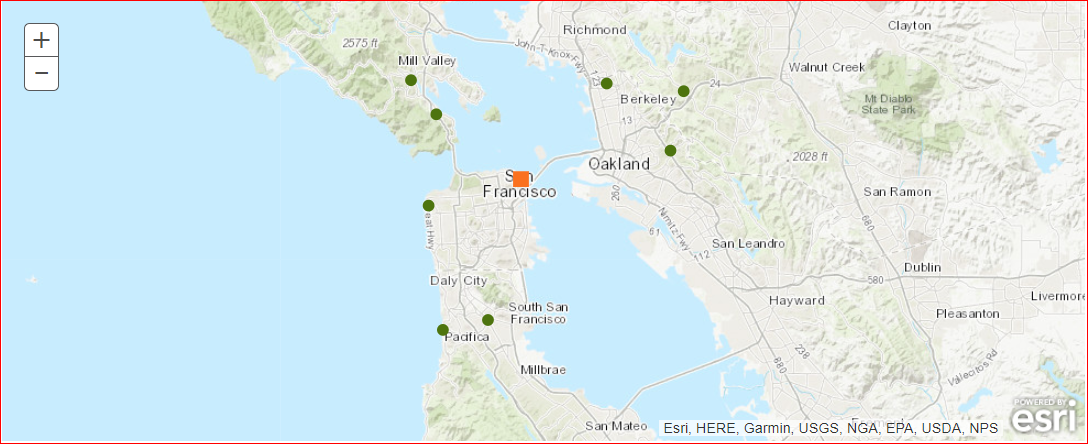

In [8]:
# Create a map instance to visualize inputs in map
map_view_inputs = my_gis.map('San Fransisco, United States', zoomlevel=10)
map_view_inputs

In [ ]:
# Visualize order and depot locations with symbology
map_view_inputs.draw(orders_fs, symbol={"type": "esriSMS","style": "esriSMSCircle","color": [76,115,0,255],"size": 8})
map_view_inputs.draw(depots_fs, symbol={"type": "esriSMS","style": "esriSMSSquare","color": [255,115,0,255], "size": 10})

Alternatively if the input data is provided in different formats, we could still create layers from those data. In practice, there might not always be csv files for all the inputs. It could be just a list of addresses or the inputs is coming from an automated script or a server output from REST API which could be in JSON format or it could be an existing feature service already on ArcGIS online or enterprise.

Let's see each of such input type and how that can be converted to feature set to input directly to the VRP service.

#### Create depots layer by geocoding the location

If we know address of depot, we would geocode the address to get the feature set to input that to the VRP solver as follows.

In [9]:
depot_geocoded_fs = geocoding.geocode("2-98 Pier 1, San Francisco, California, 94111", as_featureset=True, max_locations=1)
depot_geocoded_fs.df


,AddBldg,AddNum,AddNumFrom,AddNumTo,AddRange,Addr_type,BldgName,BldgType,Block,City,...,UnitName,UnitType,X,Xmax,Xmin,Y,Ymax,Ymin,Zone,SHAPE
0,,98,2,98,2-98,StreetAddress,,,,San Francisco,...,,,-122.39383,-122.39283,-122.39483,37.797505,37.798505,37.796505,,"{'x': -122.39383026489244, 'y': 37.79750484973..."


#### Create routes layer with JSON file
If we have json files for inputs, without needing to parse it, we could feed that to from_json service of FeatureSet and we would get feature set to input to the [VRP service](https://developers.arcgis.com/rest/network/api-reference/vehicle-routing-problem-service.htm#ESRI_SECTION3_E65DBEE0F0BF46EB946A63A2537137C5).

In [10]:
import json
with open("data/Routes_fset.json") as f:
    df1 = json.load(f)
routes_string = json.dumps(df1)    
routes_fset = FeatureSet.from_json(routes_string)
routes_string

'{"features": [{"attributes": {"StartDepotName": "Warehouse", "EndDepotName": "Warehouse", "EarliestStartTime": -2209132800000, "LatestStartTime": -2209125600000, "Capacities": "6", "CostPerUnitTime": 20, "MaxOrderCount": 6, "MaxTotalTime": 150, "AssignmentRule": 1, "Name": "Route1"}}, {"attributes": {"StartDepotName": "Warehouse", "EndDepotName": "Warehouse", "EarliestStartTime": -2209132800000, "LatestStartTime": -2209125600000, "Capacities": "6", "CostPerUnitTime": 20, "MaxOrderCount": 6, "MaxTotalTime": 150, "AssignmentRule": 1, "Name": "Route2"}}]}'

## Solve VRP
You can pass inputs in different formats. For example, depot is geocoded from address, `orders` and `routes` are read from csv files saved on local disk. As result to the solve, we get routes with geometry. If we need directions for navigation, `populate_directions` must be set to true. 

In [11]:
today = datetime.datetime.now()
results = arcgis.network.analysis.solve_vehicle_routing_problem(orders= orders_fs,
                                                         depots = depots_fs,
                                                         routes = routes_fs, 
                                                         save_route_data='true',
                                                         populate_directions='true',
                                                         travel_mode="Driving Time",
                                                         default_date=today
                                                            )
print('Analysis succeeded? {}'.format(results.solve_succeeded))

Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").



Analysis succeeded? True


## Result
Let's have a look at the output routes in the dataframe. The time values returned from VRP service are in milliseconds from epoch, we need to convert that in datetime format.

In [12]:
# Display the output routes in a pandas dataframe.
out_routes_df = results.out_routes.df

out_routes_df["EndTime"] = pd.to_datetime(out_routes_df["EndTime"]/(10 ** 3), unit='s')
out_routes_df["EndTimeUTC"] = pd.to_datetime(out_routes_df["EndTimeUTC"]/(10 ** 3), unit='s')
out_routes_df

,DistanceCost,EndTime,EndTimeUTC,Name,ObjectID,OrderCount,OvertimeCost,RegularTimeCost,RenewalCount,Shape_Length,...,TotalCost,TotalDistance,TotalOrderServiceTime,TotalRenewalServiceTime,TotalTime,TotalTravelTime,TotalViolationTime,TotalWaitTime,ViolatedConstraints,SHAPE
0,0,2019-01-23 09:59:00.093,2019-01-23 17:59:00.093,Route1,1,5,0,2380.031106,0,0.933151,...,2380.031106,55.494748,0,0,119.001555,119.001555,0,0,None,"{'paths': [[[-122.3949275, 37.79640750000004],..."
1,0,2019-01-23 09:42:56.705,2019-01-23 17:42:56.705,Route2,2,3,0,2058.901774,0,0.703202,...,2058.901774,42.030140,0,0,102.945089,102.945089,0,0,None,"{'paths': [[[-122.3949275, 37.79640750000004],..."


The information about stops sequence and which routes will service the stops, let's read out_stops output table. Similar to routes table, it has time values in milliseconds from epoch, we have converted those values to date time format. 

In the table, Route1 starts at 2019-01-17 08:00:00.000 from Warehouse, stop with `ObjectID` 1 will be served by Route1 at `sequence` number 4 and arrive at the stop 1 located at '855 La Playa St, San Francisco, California, 94121', at 2019-01-17 09:04:02.996 local time and 2019-01-17 17:04:02.996 UTC time.

In [13]:
out_stops_df = results.out_stops.df
# Convert time values to data time format.
out_stops_df["ArriveTime"] = pd.to_datetime(out_stops_df["ArriveTime"]/(10 ** 3), unit='s')
out_stops_df["ArriveTimeUTC"] = pd.to_datetime(out_stops_df["ArriveTimeUTC"]/(10 ** 3), unit='s')
out_stops_df["DepartTime"] = pd.to_datetime(out_stops_df["DepartTime"]/(10 ** 3), unit='s')
out_stops_df["DepartTimeUTC"] = pd.to_datetime(out_stops_df["DepartTimeUTC"]/(10 ** 3), unit='s')
out_stops_df

,ArriveCurbApproach,ArriveTime,ArriveTimeUTC,DeliveryQuantities,DepartCurbApproach,DepartTime,DepartTimeUTC,FromPrevDistance,FromPrevTravelTime,Name,PickupQuantities,RouteName,Sequence,StopType,ViolationTime,WaitTime
ObjectID,,,,,,,,,,,,,,,,
1,0,2019-01-23 09:04:02.996,2019-01-23 17:04:02.996,,0,2019-01-23 09:04:02.996,2019-01-23 17:04:02.996,12.613180,27.195098,"855 La Playa St, San Francisco, California, 94121",,Route1,4,0,0,0
2,0,2019-01-23 09:19:46.072,2019-01-23 17:19:46.072,,0,2019-01-23 09:19:46.072,2019-01-23 17:19:46.072,9.241272,15.717933,"90 W Manor Dr, Pacifica, California, 94044",,Route1,5,0,0,0
3,0,2019-01-23 08:36:51.290,2019-01-23 16:36:51.290,,0,2019-01-23 08:36:51.290,2019-01-23 16:36:51.290,4.136156,10.716436,"22 Plymouth Ave, Mill Valley, California, 94941",,Route1,3,0,0,0
4,0,2019-01-23 08:30:43.940,2019-01-23 16:30:43.940,,0,2019-01-23 08:30:43.940,2019-01-23 16:30:43.940,13.223967,30.732330,"801-899 Curtis St, Albany, California, 94706",,Route2,2,0,0,0
5,0,2019-01-23 08:55:05.575,2019-01-23 16:55:05.575,,0,2019-01-23 08:55:05.575,2019-01-23 16:55:05.575,8.389101,24.360579,"3-5 Camino Sobrante, Orinda, California, 94563",,Route2,3,0,0,0
6,0,2019-01-23 09:30:39.776,2019-01-23 17:30:39.776,,0,2019-01-23 09:30:39.776,2019-01-23 17:30:39.776,6.860719,10.895059,"San Mateo Superior Court-Northern, 1050 Missio...",,Route1,6,0,0,0
7,0,2019-01-23 08:26:08.304,2019-01-23 16:26:08.304,,0,2019-01-23 08:26:08.304,2019-01-23 16:26:08.304,9.689961,26.138400,"12 Kendell Ct, Sausalito, California, 94965",,Route1,2,0,0,0
8,0,2019-01-23 09:06:34.461,2019-01-23 17:06:34.461,,0,2019-01-23 09:06:34.461,2019-01-23 17:06:34.461,6.416754,11.481447,"6551-6599 Lucas Ave, Oakland, California, 94611",,Route2,4,0,0,0
9,0,2019-01-23 08:00:00.000,2019-01-23 16:00:00.000,0.000000,0,2019-01-23 08:00:00.000,2019-01-23 16:00:00.000,0.000000,0.000000,Warehouse,0.000000,Route1,1,1,0,0


Now, let us visualize the results on a map.


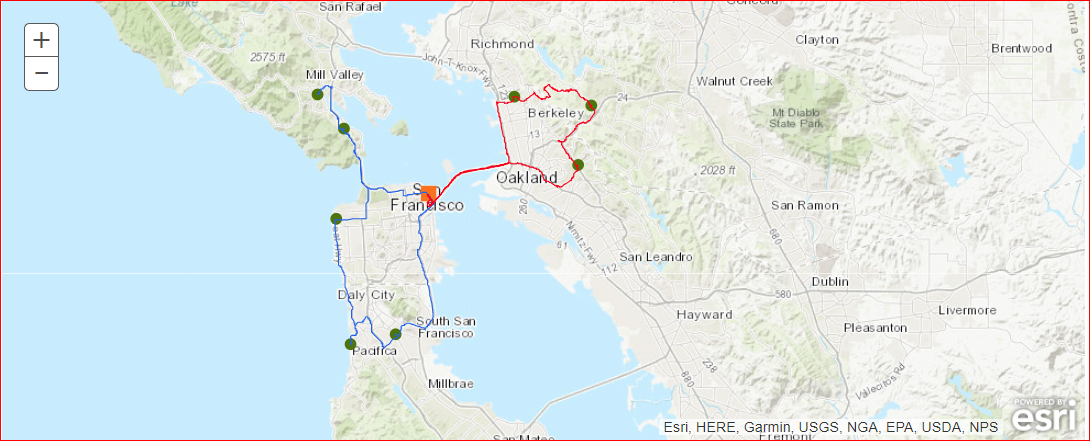

In [14]:
# Create a map instance to visualize outputs in map
map_view_outputs = my_gis.map('San Fransisco, United States', zoomlevel=10)
map_view_outputs

In [ ]:
#Visusalize the inputsn with different symbols
map_view_outputs.draw(orders_fs, symbol={"type": "esriSMS","style": "esriSMSCircle","color": [76,115,0,255],"size": 8})
map_view_outputs.draw(depots_fs, symbol={"type": "esriSMS","style": "esriSMSSquare","color": [255,115,0,255], "size": 10})
#Visualize the first route
out_routes_flist = []
out_routes_flist.append(results.out_routes.features[0])
out_routes_fset = []
out_routes_fset = FeatureSet(out_routes_flist)
map_view_outputs.draw(out_routes_fset, symbol={"type": "esriSLS","style": "esriSLSSolid","color": [0,100,240,255],"size":10})
#Visualize the second route
out_routes_flist = []
out_routes_flist.append(results.out_routes.features[1])
out_routes_fset = []
out_routes_fset = FeatureSet(out_routes_flist)
map_view_outputs.draw(out_routes_fset, symbol={"type": "esriSLS","style": "esriSLSSolid","color": [255,0,0,255],"size":10})

Save the route data from result to local disk which would then be used to upload to online portal to share with drivers eventually and share the routes in ArcGIS online on the portal you have been using. Individual routes are saved as route layers which could then be opened in navigator with directions(if you solve with 'populate_directions'=true')

In [15]:
route_data = results.out_route_data.download()
route_data_item = my_gis.content.add({"type": "File Geodatabase"}, route_data)

Create route layers from the route data. This will create route layers in the online portal which could then be shared with drivers, so they would be able to open this in navigator.

In [16]:
route_layers = arcgis.features.analysis.create_route_layers(route_data_item, delete_route_data_item=True)
for route_layer in route_layers:
    route_layer.share(org=True)
    display(route_layer.homepage)
    display(route_layer)

'https://geosaurus.maps.arcgis.com/home/item.html?id=4591e5350859488cafe72bab666aa7db'

<Item title:"Route1" type:Feature Collection owner:arcgis_python>

'https://geosaurus.maps.arcgis.com/home/item.html?id=110f59aa069f44c1ad121011453a6e93'

<Item title:"Route2" type:Feature Collection owner:arcgis_python>

The network module of the ArcGIS API for Python allows you to solve a Vehicle Routing Problem and other network problems with necessary business constraints. Learn more about how to solve VRP with business constraints [here](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.network.analysis.html#solve-vehicle-routing-problem).